## Getting started with pyplis

This notebook provides a step-by-step guide through pyplis, performing a complete evaluation of the [official pyplis test dataset](https://github.com/jgliss/pyplis#example-and-test-data) which is also used and documented in the [pyplis paper](https://www.mdpi.com/2076-3263/7/4/134/htm).

Essentially, what this notebook does is taking you on a tour through the [12 example scripts](https://github.com/jgliss/pyplis/tree/master/scripts) (i.e. scripts ex01_analysis_setup.py - ex12_emission_rate.py) that are discussed in the paper as well. The main steps that will be illustrated include (in chronological order):

1. Define analysis setup and load dataset (classes `MeasSetup, Dataset`)
2. Measurement geometry and plume distance retrieval (class `MeasGeometry`)
3. Computing optical-density images ($\tau_{on}$, $\tau_{off}$, $\tau_{AA}$ class `PlumeBackgroundModel`)

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pyplis
pyplis.change_loglevel(pyplis.logger, 'warning', update_fmt=True, fmt_debug=True)
pyplis.change_loglevel(pyplis.print_log, 'info', update_fmt=True, fmt_debug=False)

In [2]:
print('Date: {}\nPyplis v{}'.format(datetime.now(), pyplis.__version__))

Date: 2019-06-01 10:37:35.067257
Pyplis v1.4.4.dev6


**NOTE**: the pyplis version used here is newer than the latest pip and conda-forge release v1.4.3 and some cells of this notebook cannot be executed with 1.4.3. 

### 0. Preface: getting an overview

In [3]:
DATA_DIR = pyplis.inout.find_test_data()
DATA_DIR

Found test data at location: C:\Users\Jonas\my_pyplis


'C:\\Users\\Jonas\\my_pyplis\\pyplis_etna_testdata'

The camera images can be found in sub-directory `images`:

In [4]:
IMG_DIR = os.path.join(DATA_DIR, 'images')
IMG_DIR

'C:\\Users\\Jonas\\my_pyplis\\pyplis_etna_testdata\\images'

Let's have a quick-look at what this directory contains:

In [5]:
all_files = os.listdir(IMG_DIR)
# display the first 10 files
all_files[:10]

['EC2_1106307_1R02_2015091606454457_F01_Etna.fts',
 'EC2_1106307_1R02_2015091606454717_F02_Etna.fts',
 'EC2_1106307_1R02_2015091606592799_F01_Etna.fts',
 'EC2_1106307_1R02_2015091606592966_F02_Etna.fts',
 'EC2_1106307_1R02_2015091606593268_D0L_Etna.fts',
 'EC2_1106307_1R02_2015091606593410_D1L_Etna.fts',
 'EC2_1106307_1R02_2015091606593561_D0H_Etna.fts',
 'EC2_1106307_1R02_2015091606593704_D1H_Etna.fts',
 'EC2_1106307_1R02_2015091606594030_F01_Etna.fts',
 'EC2_1106307_1R02_2015091606594215_F02_Etna.fts']

As you can see, the image files are stored using the FITS standard (.fts). The camera that was used to make these measurements is the ECII camera (NILU, Norway), which uses a file naming convention that allows to extract acquisition time from the file name (e.g. 2015091606454457 => 16.09.2015 06:45:44.457 UTC), as well as information about which filter was used for a given picture (e.g. F01, F02, D0L ...). The latter is encoded and translates to:

- F01: SO2 onband filter (~310 nm)
- F02: SO2 offband filter (~330 nm)
- D0L: Dark image, shortest exposure, low gain
- D1L: Dark image, longest exposure, low gain
- D0H: Dark image, shortest exposure, high gain
- D1H: Dark image, longest exposure, high gain

These information is actually stored in the [cam_info.txt](https://github.com/jgliss/pyplis/blob/master/pyplis/data/cam_info.txt) file that contains default information about cameras that are registered in pyplis. More information about how to setup your custom camera type can be found [here](https://pyplis.readthedocs.io/en/latest/tutorials.html#primer-on-data-import).

#### 0.1 Quicklook at some example images

Before diving into the analysis, let's have a quick look at one onband, offband and dark image. Images in pyplis are represented by the `Img` class and can be loaded simply by passing the file path:

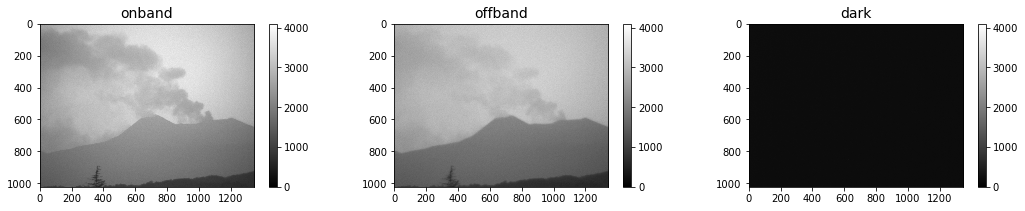

In [12]:
# Locate the images
onband_file = os.path.join(IMG_DIR, all_files[0])
offband_file = os.path.join(IMG_DIR, all_files[1])
dark_file = os.path.join(IMG_DIR, all_files[5])

# Load them
on_img = pyplis.Img(onband_file)
off_img = pyplis.Img(offband_file)
dark_img = pyplis.Img(dark_file)

# And plot them
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 3))
on_img.show(ax=ax1, vmin=0, vmax=2**12, tit='onband')
off_img.show(ax=ax2, vmin=0, vmax=2**12, tit='offband')
dark_img.show(ax=ax3, vmin=0, vmax=2**12, tit='dark');

Apart from the image data itself, each image also contains metadata as well as information about what editing has been applied to the image. You can use the print command of the image class to see these information:

In [13]:
print(on_img)


-----------
pyplis Img
-----------

Min / Max intensity: 477.0 - 4095.0
Mean intensity: 2597.7518681117467
Shape: (1024, 1344)
ROI (abs. coords): [0, 0, 1344, 1024]

Meta information
-------------------
start_acq: 1900-01-01 00:00:00
stop_acq: 1900-01-01 00:00:00
texp: 0.0
focal_length: nan
pix_width: nan
pix_height: nan
bit_depth: nan
f_num: nan
read_gain: 0
lon: nan
lat: nan
altitude: nan
altitude_offs: nan
elev: nan
elev_err: nan
azim: nan
azim_err: nan
filter_id: 
path: C:\Users\Jonas\my_pyplis\pyplis_etna_testdata\images\EC2_1106307_1R02_2015091606454457_F01_Etna.fts
file_name: EC2_1106307_1R02_2015091606454457_F01_Etna.fts
file_type: .fts
device_id: 
ser_no: 
wvlngth: nan
fits_idx: 0
temperature: nan
user_param1: nan
user_param2: nan
user_param3: nan

Edit log
-----------
darkcorr: False
blurring: 0
median: 0
crop: False
8bit: False
pyrlevel: 0
is_tau: False
is_aa: False
vigncorr: False
senscorr: False
dilcorr: False
gascalib: False
is_bin: False
is_inv: False
shifted: False
oth

As you can see, most meta information is unspecified. This is because the we loaded the image file without specifying any further information that may be used to load the metadata. *pyplis* can access metadata both from image filenames and also metadata stored within the file itself. These information can be provided in the `Camera` class, which is introduced in the following section. 

### 1. Define your analysis setup 

Before getting into the interesting stuff, *pyplis* needs to know a bunch of things from you regarding the measurement data that is supposed to be analysed. These include:

- Information about the camera (e.g. optics, location, viewing direction) -> `Camera` class
- Information about the source and meteorology (e.g. source location, wind direction)

#### 1.1 The `Camera` class

Information related to the camera is stored in the `Camera` class:

In [16]:
cam = pyplis.Camera()
print(cam)

None, serno. 9999
-------------------------
cam_id: None
delim: .
time_info_pos: None
time_info_str: 
filter_id_pos: None
texp_pos: None
texp_unit: ms
file_type: None
main_filter_id: None
meas_type_pos: None
darkcorr_opt: 0
focal_length: None
pix_height: None
pix_width: None
pixnum_x: None
pixnum_y: None
reg_shift_off: [0.0, 0.0]
io_opts: {}
image_import_method: None

Dark & offset info
------------------------

Filters
----------------------
on, type: on (default): nan nm
Default Filter: on

Geometry info
----------------------
lon: None
lat: None
altitude: None
azim: None
azim_err: None
elev: None
elev_err: None
alt_offset: 0.000



The output above shows, which parameters are relevant for the camera setup. These include information about optics and geo-location and viewing direction, but also about the associated file-naming convention, that may be used to access image meta-information from the image filenames (if applicable). 

If your camera is registered in pyplis (i.e. specs are available in file [cam_info.txt]() you may use your camera ID to register further camera specific information when loading an image: 

To get a list of all valid camera ID's, you can call:

In [8]:
all_cam_names = pyplis.inout.get_all_valid_cam_ids()
print(all_cam_names)

['hdcam', 'hd', 'HD', 'HDCam', 'ecII', 'ec2', 'ECII', 'EC2', 'EnvicamII', 'PCO', 'pco', 'pco.ultraviolet', 'PCO.ultraviolet', 'hd_new', 'usgs', 'usgs_12mm', 'usgs', 'usgs_9mm', 'ecII_new_test', 'comtessa', 'nilu', 'NILU', '']


To get camera specific information about one of these ID's you can create an instance of the `Camera` class, which loads all available information for this camera from the `cam_info.txt` file. As is indicated in the image filenames above, the camera used here, has `EC2` as ID. 

In [9]:
cam = pyplis.Camera('EC2')
print(cam)

ecII, serno. 9999
-------------------------
cam_id: ecII
delim: _
time_info_pos: 3
time_info_str: %Y%m%d%H%M%S%f
filter_id_pos: 4
texp_pos: None
texp_unit: 
file_type: fts
main_filter_id: on
meas_type_pos: 4
darkcorr_opt: 1
focal_length: None
pix_height: 4.65e-06
pix_width: 4.65e-06
pixnum_x: 1344
pixnum_y: 1024
reg_shift_off: [0.0, 0.0]
io_opts: {}
image_import_method: <function load_ecII_fits at 0x0000024AC06D42F0>

Dark & offset info
------------------------
ID: offset0, type: offset, acronym: D0L, meas_type_acro: D0L,read_gain: 0
ID: dark0, type: dark, acronym: D1L, meas_type_acro: D1L,read_gain: 0
ID: offset1, type: offset, acronym: D0H, meas_type_acro: D0H,read_gain: 1
ID: dark1, type: dark, acronym: D1H, meas_type_acro: D1H,read_gain: 1

Filters
----------------------
on, type: on (F01): 310 nm
off, type: off (F03): 330 nm
Default Filter: on

Geometry info
----------------------
lon: None
lat: None
altitude: None
azim: None
azim_err: None
elev: None
elev_err: None
alt_offset: 0.

From the output you can see that the default information is loaded, which includes information about pixel size, or naming conventions for dark and offset images (i.e. translation of abbreviations into machine understandable settings that can be interpreted by pyplie (e.g. `read_gain=0/1, type=offset/dark` and so on) and default filters.

For the latter you can see that the default uses `F03` as abbreviation for the offband filter but from the file output above, the abbr. is `F02` (which is due to different versions of this camera type). 
This can be updated in the camera filter setup:

In [10]:
print(cam.filter_setup) 

on, type: on (F01): 310 nm
off, type: off (F03): 330 nm
Default Filter: on



From the output above you can also see that the `Camera` class also includes geolocation attributes such as `lat, lon, altitude` which are used to compute the measurement geometry when defining the measurement setup. 

In [11]:
cam.filter_setup['off'] = pyplis.Filter(id='off', type='off', acronym='F02')

setupclasses.py(l424,__setitem__()): Filter with ID off already exists in FilterSetup and will be overwritten


The most important attributes that need to be defined when creating an instance of `Filter` class are `type` and `acronym` as these will be used by pyplis to separate different image types. The latter is being done automatically in the `pyplis.Dataset` object (more below).

In the following, relevant parameter for the analysis are defined. From these, an instance of the class `AnalysisSetup` is created, which is used to create an instance of the `Dataset` class.

Define start and stop time of the measurement

In [14]:
start_plume = datetime(2015, 9, 16, 7, 6, 0)
stop_plume = datetime(2015, 9, 16, 7, 22, 0)

# Define camera (here the default ecII type is used)
cam_id = "ecII"

# the camera filter setup
filters = [pyplis.utils.Filter(type="on", acronym="F01"),
           pyplis.utils.Filter(type="off", acronym="F02")]

# camera location and viewing direction (altitude will be retrieved
# automatically)
geom_cam = {"lon": 15.1129,
            "lat": 37.73122,
            "elev": 20.0,
            "elev_err": 5.0,
            "azim": 270.0,
            "azim_err": 10.0,
            "alt_offset": 15.0,
            "focal_length": 25e-3}  # altitude offset (above topography)

# Create camera setup
# the camera setup includes information about the filename convention in
# order to identify different image types (e.g. on band, off band, dark..)
# it furthermore includes information about the detector specifics (e.g.
# dimension, pixel size, focal length). Measurement specific parameters
# (e.g. lon, lat, elev, azim) where defined in the dictinary above and
# can be passed as additional keyword dictionary using **geom_cam
# Alternatively, they could also be passed directly, e.g.:

# cam = pyplis.setup.Camera(cam_id, filter_list=filters, lon=15.1129,
#                           lat=37.73122)

cam = pyplis.setupclasses.Camera(cam_id, filter_list=filters,
                                 **geom_cam)

# Load default information for Etna. This information is stored in
# the source_info.txt file of the Pyplis information. You may also access
# information about any volcano via the available online access to the NOAA
# database using the method pyplis.inout.get_source_info_online(source_id).

source = pyplis.setupclasses.Source("etna")

# Provide wind direction
wind_info = {"dir": 0.0,
             "dir_err": 1.0}

#                "dir_err"  : 15.0}

# Create BaseSetup object (which creates the MeasGeometry object)
stp = pyplis.setupclasses.MeasSetup(IMG_DIR, start_plume, stop_plume, 
                                    camera=cam,
                                    source=source,
                                    wind_info=wind_info)
print(stp.LINK_OFF_TO_ON)
# Create analysis object (from BaseSetup)
# The dataset takes care of finding all vali
ds = pyplis.Dataset(stp)

NameError: name 'start' is not defined